In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [83]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [84]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

# Calculate weights for weighted moving averages
weights_short = np.arange(1, short_window + 1)
weights_long = np.arange(1, long_window + 1)

# Calculate weighted moving averages
signals['short_ma'] = df['Close'].rolling(window=short_window).apply(lambda x: np.average(x, weights=weights_short), raw=True)
signals['long_ma'] = df['Close'].rolling(window=long_window).apply(lambda x: np.average(x, weights=weights_long), raw=True)

# Generate buy/sell signals
signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0)
signals['signal'] = signals['signal'].shift(1)  # Shift the signal by one day to prevent look-ahead bias
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN
2,0.0,NaN,NaN,0.0
3,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,0.0
...,...,...,...,...
247,0.0,973.827146,979.682823,0.0
248,0.0,986.117150,985.195133,0.0
249,1.0,996.131906,989.990259,1.0
250,1.0,1004.635719,994.337697,0.0


The signals DataFrame contains the following columns:
•	Close: The closing price of the stock on each day.

•	short_ma: The weighted moving average of the closing price over the short window.


•	long_ma: The weighted moving average of the closing price over the long window.

•	signal: A binary signal that indicates whether to buy (1) or sell (0) the stock on each day.


•	positions: The cumulative sum of the signal column. This column indicates the number of shares of the stock that are currently held.

The signal column is generated by comparing the short-term and long-term moving averages. When the short-term moving average crosses above the long-term moving average, a buy signal is generated. When the short-term moving average crosses below the long-term moving average, a sell signal is generated.

The positions column is generated by cumulating the signal column. This column indicates the number of shares of the stock that are currently held. For example, if the signal column is 1 on a given day, then the positions column will be incremented by 1 on that day. If the signal column is 0 on a given day, then the positions column will be decremented by 1 on that day.

The signals DataFrame can be used to generate trading signals. For example, a trader could buy the stock when the signal column is 1 and sell the stock when the signal column is 0.

In [85]:
def buy_stock(
    real_movement,
    signal,
    money=10000,
    max_buy=1,
    max_sell=1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = money
    states_sell = []
    states_buy = []
    holdings = 1

    def buy(i, money, holdings):
        shares = money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            money -= buy_units * real_movement[i]
            holdings += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], money)
            )
            states_buy.append(0)
        return money, holdings

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            money, holdings = buy(
                i, money, holdings
            )
            states_buy.append(i)
        elif state == -1:
            if holdings == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if holdings > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = holdings
                holdings -= sell_units
                total_sell = sell_units * real_movement[i]
                money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, money)
                )
            states_sell.append(i)
    invest = ((money - starting_money) / starting_money) * 100
    total_gains = money - starting_money
    return states_buy, states_sell, total_gains, invest

In [86]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 14: buy 1 units at price 768.270020, total balance 9231.729980
day 20, sell 1 units at price 747.919983, investment -2.648813 %, total balance 9979.649963,
day 26: buy 1 units at price 789.289978, total balance 9190.359985
day 37, sell 1 units at price 791.549988, investment 0.286335 %, total balance 9981.909973,
day 45: buy 1 units at price 806.650024, total balance 9175.259949
day 54, sell 1 units at price 819.309998, investment 1.569451 %, total balance 9994.569947,
day 55: buy 1 units at price 823.869995, total balance 9170.699952
day 61, sell 1 units at price 795.695007, investment -3.419834 %, total balance 9966.394959,
day 68: buy 1 units at price 813.669983, total balance 9152.724976
day 84, sell 1 units at price 831.909973, investment 2.241694 %, total balance 9984.634949,
day 85: buy 1 units at price 835.369995, total balance 9149.264954
day 96, sell 1 units at price 817.580017, investment -2.129593 %, total balance 9966.844971,
day 103: buy 1 units at price 838.549988, t

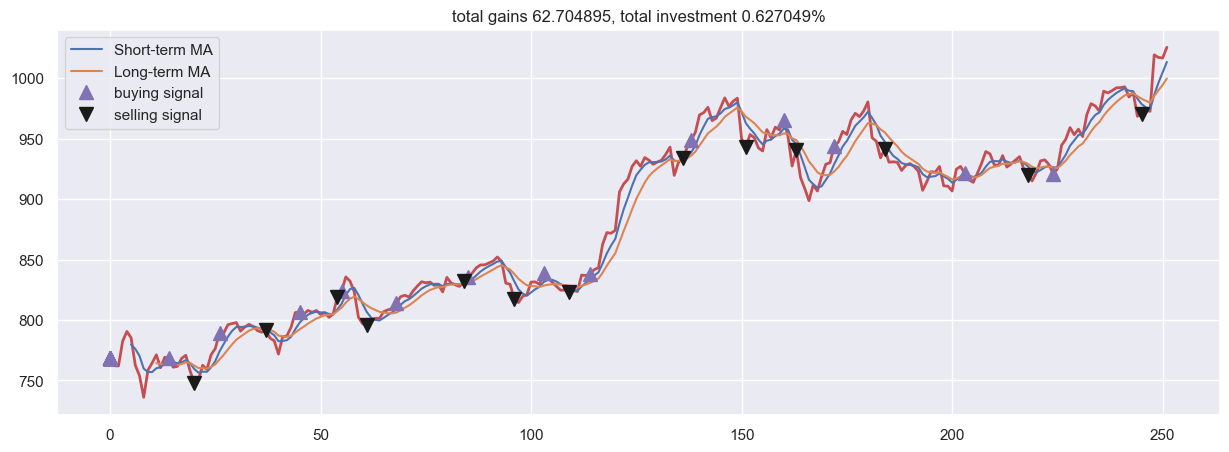

In [87]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2)
# Plot moving average lines
plt.plot(signals['short_ma'], label='Short-term MA')
plt.plot(signals['long_ma'], label='Long-term MA')
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

Calculating Weighted Moving Averages and generating Signals, have time complexities ranging from O(n) to O(n^2), depending on the specific implementation details.
Hence worst-case time complexity is O(n^2).